In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import sys
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import IPython as IPy
import sklearn as skl
from sklearn.model_selection import train_test_split

import os
import tarfile
import urllib

import joblib

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
## DATASET

In [4]:
dataset = pd.read_csv("../datasets/arrhythmia/arrhythmia.data", header=None, na_values="?")

In [5]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,53,1,160,70,80,199,382,154,117,-37,...,0.0,4.3,-5.0,0.0,0.0,0.7,0.6,-4.4,-0.5,1
448,37,0,190,85,100,137,361,201,73,86,...,0.0,15.6,-1.6,0.0,0.0,0.4,2.4,38.0,62.4,10
449,36,0,166,68,108,176,365,194,116,-85,...,0.0,16.3,-28.6,0.0,0.0,1.5,1.0,-44.2,-33.2,2
450,32,1,155,55,93,106,386,218,63,54,...,-0.4,12.0,-0.7,0.0,0.0,0.5,2.4,25.0,46.6,1


In [6]:
arr = dataset[279].unique()
arr.sort()
arr

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16], dtype=int64)

In [7]:
len(arr)

13

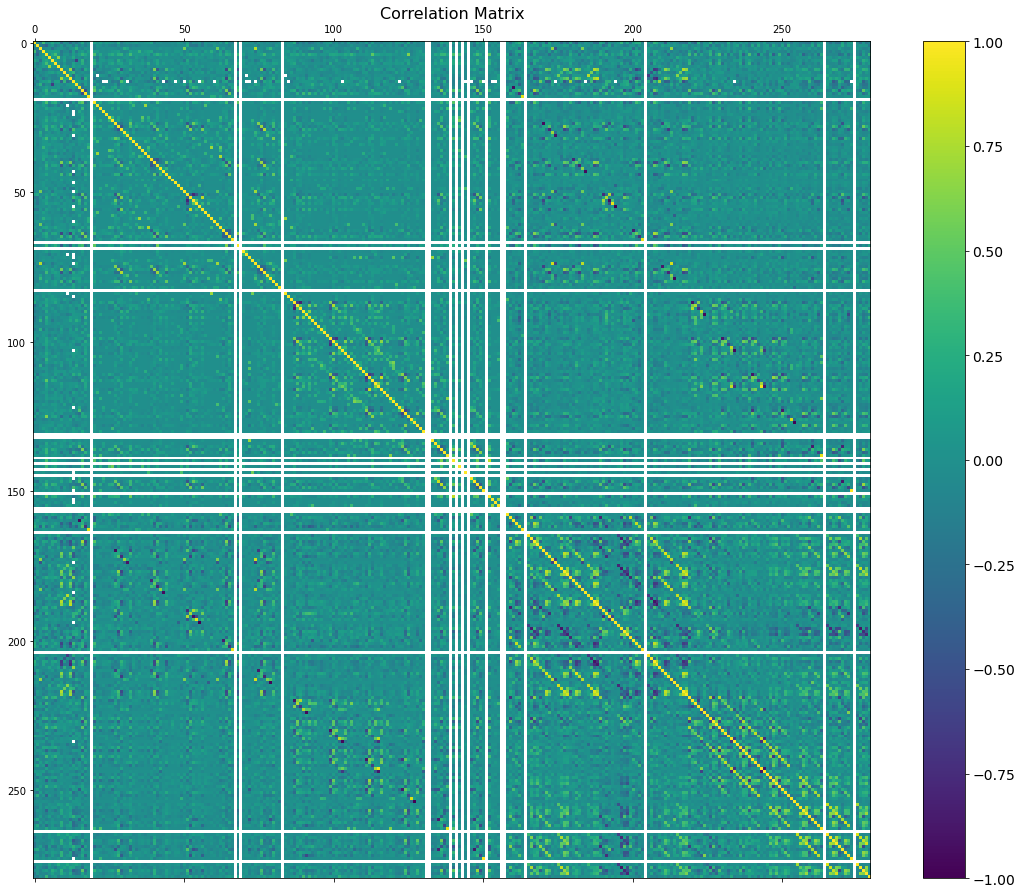

In [8]:
fig = plt.figure(figsize=(19, 15))
plt.matshow(dataset.corr(), fignum=fig.number)
#plt.xticks(range(dataset.shape[1]), dataset.columns, fontsize=14, rotation=45)
#plt.yticks(range(dataset.shape[1]), dataset.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(dataset, dataset[279]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [10]:
X_train_raw = strat_train_set.drop(279, axis=1)
y_train = strat_train_set[279].copy()

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

problem_features_ixs = [13]

class FeatureDeleter(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        for i in problem_features_ixs:
            X = np.delete(X, i, axis = 1)
        return X

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('feature_eraser', FeatureDeleter()), #for whatever reason this must be after the SimpleImputer...
                         ('std_scaler', StandardScaler()),
                        ])

X_train = num_pipeline.fit_transform(X_train_raw) 

In [13]:
## ALGOS

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

for n_neighbors in range (1, 8):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X_train, y_train)
    score = cross_val_score(knn, X_train, y_train, cv=2, scoring="accuracy")
    print("K-NN with {} neighbors: {}. Mean score: {}".format(n_neighbors, score, np.mean(score)))

K-NN with 1 neighbors: [0.52486188 0.55555556]. Mean score: 0.5402087170042971
K-NN with 2 neighbors: [0.54696133 0.62222222]. Mean score: 0.5845917740945366
K-NN with 3 neighbors: [0.54696133 0.64444444]. Mean score: 0.5957028852056476
K-NN with 4 neighbors: [0.56353591 0.59444444]. Mean score: 0.5789901780233272
K-NN with 5 neighbors: [0.54696133 0.62777778]. Mean score: 0.5873695518723143
K-NN with 6 neighbors: [0.56353591 0.6       ]. Mean score: 0.581767955801105
K-NN with 7 neighbors: [0.55248619 0.57777778]. Mean score: 0.5651319828115409


In [15]:
from sklearn.linear_model import LogisticRegression

for C in [2, 1, 0.75, 0.5, 0.25, 0.01]:
    log_reg = LogisticRegression(C = C, max_iter = 100000, random_state = 42).fit(X_train, y_train)
    score = cross_val_score(log_reg, X_train, y_train, cv=2, scoring="accuracy")
    print("LogReg with C = {}: {}. Mean score: {}".format(C, score, np.mean(score)))

LogReg with C = 2: [0.66850829 0.68888889]. Mean score: 0.6786985880908533
LogReg with C = 1: [0.67403315 0.70555556]. Mean score: 0.6897943523634131
LogReg with C = 0.75: [0.67403315 0.69444444]. Mean score: 0.6842387968078576
LogReg with C = 0.5: [0.67955801 0.7       ]. Mean score: 0.6897790055248618
LogReg with C = 0.25: [0.66298343 0.71666667]. Mean score: 0.6898250460405156
LogReg with C = 0.01: [0.64640884 0.66666667]. Mean score: 0.656537753222836


In [16]:
#the best
log_reg = LogisticRegression(C = 0.5, max_iter = 100000, random_state = 42).fit(X_train, y_train)

In [17]:
from sklearn.svm import LinearSVC

for C in [0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0009, 0.0007]:
    lin_svc = LinearSVC(C = C, max_iter = 100000, random_state = 42).fit(X_train, y_train)
    score = cross_val_score(lin_svc, X_train, y_train, cv=2, scoring="accuracy")
    print("LogReg with C = {}: {}. Mean score: {}".format(C, score, np.mean(score)))

LogReg with C = 0.01: [0.6519337  0.68888889]. Mean score: 0.6704112952731738
LogReg with C = 0.0075: [0.64640884 0.68888889]. Mean score: 0.6676488643339472
LogReg with C = 0.005: [0.64640884 0.71111111]. Mean score: 0.6787599754450584
LogReg with C = 0.0025: [0.64088398 0.72222222]. Mean score: 0.6815531000613874
LogReg with C = 0.001: [0.6519337  0.71666667]. Mean score: 0.6843001841620626
LogReg with C = 0.0009: [0.6519337  0.71666667]. Mean score: 0.6843001841620626
LogReg with C = 0.0007: [0.65745856 0.71111111]. Mean score: 0.6842848373235113


In [18]:
#the best
lin_svc = LinearSVC(C = 0.001, max_iter = 100000, random_state = 42).fit(X_train, y_train)

In [19]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

ran_for = RandomForestClassifier(random_state = 42).fit(X_train, y_train)
score = cross_val_score(ran_for, X_train, y_train, cv=2, scoring="accuracy")
print("RanForest: {}. Mean score: {}".format(score, np.mean(score)))

RanForest: [0.67403315 0.71111111]. Mean score: 0.6925721301411909


In [20]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(random_state = 42).fit(X_train, y_train)
score = cross_val_score(dec_tree, X_train, y_train, cv=2, scoring="accuracy")
print("DecTree: {}. Mean score: {}".format(score, np.mean(score)))

DecTree: [0.66298343 0.58333333]. Mean score: 0.623158379373849


In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42).fit(X_train, y_train)
score = cross_val_score(sgd_clf, X_train, y_train, cv=2, scoring="accuracy")
print("SGD: {}. Mean score: {}".format(score, np.mean(score)))

SGD: [0.61878453 0.63333333]. Mean score: 0.6260589318600368


In [22]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost = GradientBoostingClassifier().fit(X_train, y_train)
score = cross_val_score(grad_boost, X_train, y_train, cv=2, scoring="accuracy")
print("Boosting: {}. Mean score: {}".format(score, np.mean(score)))

Boosting: [0.70718232 0.72777778]. Mean score: 0.7174800491098834


In [23]:
#Fine-tuning RanForest and GradBoost?

In [24]:
## CONFUSION MATRIX

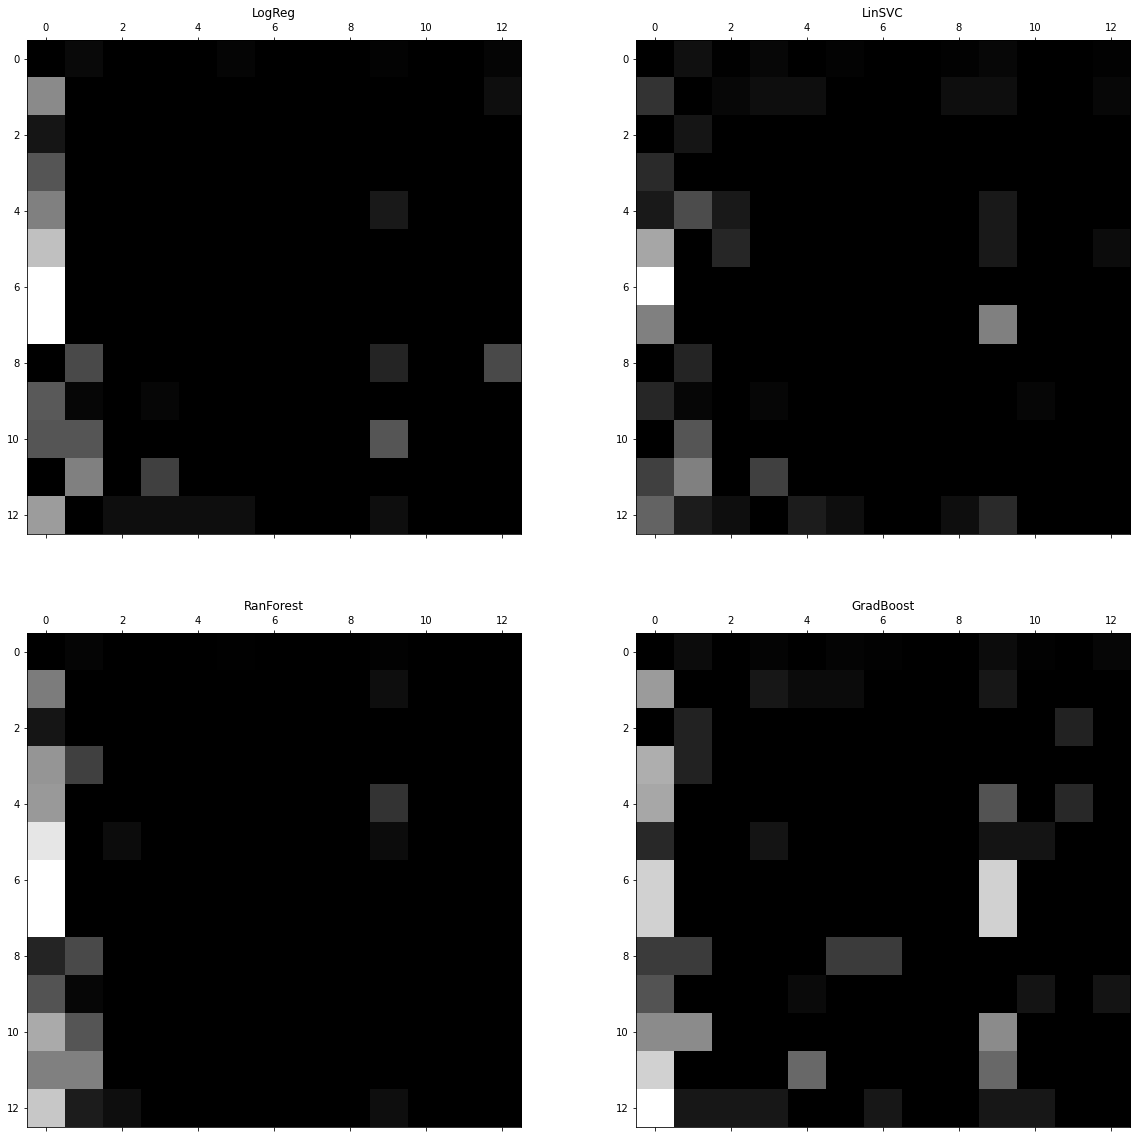

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

models = [log_reg, lin_svc, ran_for, grad_boost]
names = ['LogReg', 'LinSVC', 'RanForest', 'GradBoost']
ixs = [0, 1, 2, 3]

fig, axes = plt.subplots(2, 2)

for i, model in zip(ixs, models):
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=2)
    conf_mx = confusion_matrix(y_train, y_train_pred)
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    axes[int(i/2), int(i%2)].matshow(norm_conf_mx, cmap=plt.cm.gray)
    axes[int(i/2), int(i%2)].set_title(names[i]);
    
fig.set_figwidth(20)
fig.set_figheight(20)
plt.show()

#1-st, 2-nd and 10-th classes are often being a misclassification (especially 1-st)

In [26]:
#Todo: analyse it in some way

In [27]:
## FINAL SCORES

In [28]:
#Try final part?
X_test_raw = strat_test_set.drop(279, axis=1)
y_test = strat_test_set[279].copy()

X_test = num_pipeline.fit_transform(X_test_raw)

In [29]:
from sklearn.metrics import accuracy_score

for name, model in zip(names, models):
    y_final = model.predict(X_test)
    final_score = accuracy_score(y_test, y_final)
    print("{} final score: {}".format(name, final_score))

LogReg final score: 0.7032967032967034
LinSVC final score: 0.7032967032967034
RanForest final score: 0.7472527472527473
GradBoost final score: 0.7472527472527473
